In [9]:
import os

In [10]:
custom_model = 'my_ssd_mobnet'
labelmap_name = 'label_map.pbtxt'

In [11]:
paths = {
    'WORKSPACE': os.path.join('Capstone', 'workspace'),
    'APIMODEL': os.path.join('Capstone','models'),
    'ANNOTATION': os.path.join('Capstone', 'workspace','annotations')
 }

In [12]:
files = {
    'PIPELINE_CONFIG':os.path.join('Capstone', 'workspace','models', custom_model, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION'], labelmap_name)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
      !mkdir -p {path}

## Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [6]:
!git clone https://github.com/tensorflow/models {paths['APIMODEL']}

Cloning into 'Capstone/models'...
remote: Enumerating objects: 86083, done.
remote: Counting objects: 100% (1682/1682), done.
remote: Compressing objects: 100% (693/693), done.
remote: Total 86083 (delta 1068), reused 1546 (delta 971), pack-reused 84401
Receiving objects: 100% (86083/86083), 598.82 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (61561/61561), done.


In [7]:
# Install the Object Detection API
%%bash
cd Capstone/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Capstone/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 14.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requiremen

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import glob
from pathlib import Path
import pandas as pd
import io
import xml.etree.ElementTree as ET

import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
#There are six labels
labels = [{'name':'bawang putih', 'id':1}, {'name':'bawang merah', 'id':2}, {'name':'daun bawang', 'id':3}, {'name':'tahu', 'id':4}, {'name':'telur', 'id':5}, {'name':'tempe', 'id':6}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [3]:
!cp /content/drive/MyDrive/C23-PS457/Machine_Learning/tflite_export.zip /content

In [4]:
!unzip -q tflite_export.zip

In [6]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('/content/content/Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('/content/content/Tensorflow/workspace/models/my_ssd_mobnet', 'ckpt-16')).expect_partial()

In [18]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

Copy the images zip files and unzip it

In [15]:
!cp /content/drive/MyDrive/C23-PS457/Machine_Learning/images.zip /content

In [16]:
!unzip -q images.zip

Test Image

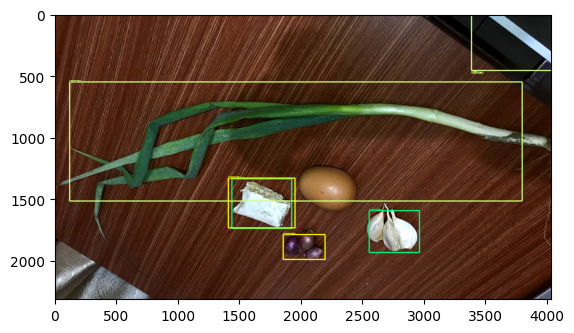

In [19]:
import cv2

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

#Change the path of the image
image = cv2.imread('/content/images/208.jpg')
image_np = np.array(image)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=0.3,
            line_thickness=10,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
min_score = 0.3
classes = detections['detection_classes'] + label_id_offset
scores = detections['detection_scores']

results = list({category_index[int(i)]['name'] for i, score in zip(classes, scores) if score > min_score})

print(results)

['daun bawang', 'bawang merah', 'tahu', 'bawang putih']
